In [1]:
import argparse
import copy
import os
import sys

# Libs and helpers
from collections import OrderedDict

import numpy as np
import scipy.linalg
import tensorflow as tf

import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.utils.tf_utils import tf_project_to_comp, tf_abs, tf_unitary_overlap
import four_level_transmons.custom_gates as custom_gates
from c3.experiment import Experiment as Exp
# Main C3 objects
from c3.libraries import constants
from c3.model import Model as Mdl
from c3.optimizers.optimalcontrol import OptimalControl
from c3.parametermap import ParameterMap as PMap
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.custom_envelopes import *
from four_level_transmons.plotting import *
from four_level_transmons.utilities import *

tf.config.run_functions_eagerly(True)

2022-05-24 15:46:54.391872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 15:46:54.391907: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# main parameters
qubit_levels = [4, 4]
qubit_frequencies = [5e9, 4.5e9]
anharmonicities = [-300e6, -200e6]
t1s = [25e-6, 25e-6]
t2stars = [35e-6, 35e-6]
qubit_temps = [50e-3, 50e-3]

In [3]:
# labels for all states
level_labels = []
for i in range(qubit_levels[0]):
    for j in range(qubit_levels[1]):
        if i > 3 or j > 3:
            level_labels.append(None)
        else:
            level_labels.append(f"{i},{j}")

In [4]:
# find energy eigenvalues and eigenvectors
qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                      t2stars, qubit_temps)
model = Mdl(qubits, [])
model.set_lindbladian(False)
model.set_dressed(False)
model.set_FR(False)
H = model.get_Hamiltonian().numpy()
evals,evecs = scipy.linalg.eig(H)
evals = evals.real / (2 * np.pi)

# find labels corresponding to states
stateEnergies = []
stateLabels = []
for i, x in enumerate(level_labels):
    #if level_labels[i] is not None:
    energy = evals[i]
    stateEnergies.append(energy)
    stateLabels.append(x)
    print(i, stateLabels[i], stateEnergies[i])

0 0,0 0.0
1 0,1 4500000000.0
2 0,2 8800000000.000002
3 0,3 12899999999.999998
4 1,0 5000000000.0
5 1,1 9500000000.0
6 1,2 13800000000.000004
7 1,3 17900000000.0
8 2,0 9700000000.000002
9 2,1 14200000000.000002
10 2,2 18500000000.000004
11 2,3 22600000000.000004
12 3,0 14099999999.999996
13 3,1 18599999999.999996
14 3,2 22900000000.0
15 3,3 26999999999.999996


2022-05-24 15:46:58.401003: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 15:46:58.401063: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 15:46:58.401098: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost.localdomain): /proc/driver/nvidia/version does not exist


In [5]:
# list all transitions
indices = np.argsort(stateEnergies)
sortedEnergies = np.array(stateEnergies)[indices]
sortedLabels = np.array(stateLabels)[indices]
#sortedEnergiesLabels = sorted(zip(stateEnergies, stateLabels), key=lambda x: x[0])
transitionEnergies = []
transitionLabels = []
transitionStateIndices = []
for i in range(len(sortedEnergies)):
    for j in range(i + 1, len(sortedEnergies)):
        E = sortedEnergies[j] - sortedEnergies[i]
        if E > 0:
            transitionEnergies.append(E)
            transitionLabels.append(sortedLabels[i] + " - " + sortedLabels[j])
            transitionStateIndices.append((i, j))

for i in range(len(transitionEnergies)):
    print(i, transitionLabels[i], transitionStateIndices[i], transitionEnergies[i])

0 0,0 - 0,1 (0, 1) 4500000000.0
1 0,0 - 1,0 (0, 2) 5000000000.0
2 0,0 - 0,2 (0, 3) 8800000000.000002
3 0,0 - 1,1 (0, 4) 9500000000.0
4 0,0 - 2,0 (0, 5) 9700000000.000002
5 0,0 - 0,3 (0, 6) 12899999999.999998
6 0,0 - 1,2 (0, 7) 13800000000.000004
7 0,0 - 3,0 (0, 8) 14099999999.999996
8 0,0 - 2,1 (0, 9) 14200000000.000002
9 0,0 - 1,3 (0, 10) 17900000000.0
10 0,0 - 2,2 (0, 11) 18500000000.000004
11 0,0 - 3,1 (0, 12) 18599999999.999996
12 0,0 - 2,3 (0, 13) 22600000000.000004
13 0,0 - 3,2 (0, 14) 22900000000.0
14 0,0 - 3,3 (0, 15) 26999999999.999996
15 0,1 - 1,0 (1, 2) 500000000.0
16 0,1 - 0,2 (1, 3) 4300000000.000002
17 0,1 - 1,1 (1, 4) 5000000000.0
18 0,1 - 2,0 (1, 5) 5200000000.000002
19 0,1 - 0,3 (1, 6) 8399999999.999998
20 0,1 - 1,2 (1, 7) 9300000000.000004
21 0,1 - 3,0 (1, 8) 9599999999.999996
22 0,1 - 2,1 (1, 9) 9700000000.000002
23 0,1 - 1,3 (1, 10) 13400000000.0
24 0,1 - 2,2 (1, 11) 14000000000.000004
25 0,1 - 3,1 (1, 12) 14099999999.999996
26 0,1 - 2,3 (1, 13) 18100000000.000004
2

In [126]:
# calculate eigenvalues for a range of coupling strengths
def getEnergies(couplingStrength: float) -> np.array:
    # Initialise the qubits and drive lines
    qubits = createQubits(qubit_levels, qubit_frequencies, anharmonicities, t1s,
                          t2stars, qubit_temps)
    coupling = createChainCouplings([couplingStrength], qubits)

    # Create the model
    model = Mdl(qubits, coupling)
    model.set_lindbladian(False)
    model.set_dressed(False)
    model.set_FR(False)

    # all energy levels with labels
    H = model.get_Hamiltonian().numpy()
    evals,evecs = scipy.linalg.eig(H)
    return evals.real / (2 * np.pi)

couplings = np.linspace(0, 50e6, 100)
allEnergies = np.empty(shape=(16,0))
for coupling in couplings:
    #print(coupling)
    energies = getEnergies(coupling)
    energies = np.sort(energies)
    allEnergies = np.append(allEnergies, np.reshape(energies, (16,1)), axis=1)

In [156]:
w1, w2 = qubit_frequencies
l1, l2 = anharmonicities
delta = w1 - w2
w = w1 + w2

analyticalEnergies = np.empty(shape=(16,len(couplings)))
for state in np.arange(16):
    n1 = state // 4
    n2 = state % 4
    E0 = (n1 * w1 + n2 * w2)
    E1 = 0.5 * (l1 * n1 * (n1 - 1) + l2 * n2 * (n2 - 1))
    E2 = 0
    A = (delta + l1 * (n1 - 1) - l2 * n2)
    E2 += n1 * (n2 + 1) / A if A != 0 else 0
    B = delta + l1 * n1 - l2 * (n2 - 1)
    E2 -= n2 * (n1 + 1) / B if B != 0 else 0
    C = w + l1 * (n1 - 1) + l2 * (n2 - 1)
    E2 += n1 * n1 / C if C != 0 else 0
    D = w + l1 * n1 + l2 * n2
    E2 -= (n1 + 1) * (n2 + 1) / D if D != 0 else 0
    print(state, n1, n2)
    #E2 = (couplings ** 2 / delta) * (n1 - n2) - (couplings ** 2 / w) * (n1 + n2 + 1)
    #E3 = -(couplings ** 2 / delta ** 2) * (n1 - n2) * (l1 * n1 * (n1 - 1) + l2 * n2 * (n2 - 1))
    E2 *= couplings ** 2
    print(state, E0, E1, E2[-1])
    analyticalEnergies[state] = (E0 + E1) * np.ones_like(couplings) + E2

0 0 0
0 0.0 0.0 -263157.8947368421
1 0 1
1 4500000000.0 0.0 -5537634.408602151
2 0 2
2 9000000000.0 -200000000.0 -7967032.967032967
3 0 3
3 13500000000.0 -600000000.0 -9456928.838951312
4 1 0
4 5000000000.0 0.0 4714253.6978933215
5 1 1
5 9500000000.0 -0.0 -18705096.07351713
6 1 2
6 14000000000.0 -200000000.0 -18102394.916911047
7 1 3
7 18500000000.0 -600000000.0 -17959947.029714473
8 2 0
8 10000000000.0 -300000000.0 25221133.15802056
9 2 1
9 14500000000.0 -300000000.0 99362818.59070463
10 2 2
10 19000000000.0 -500000000.0 -126535947.7124183
11 2 3
11 23500000000.0 -900000000.0 -52478094.19496166
12 3 0
12 15000000000.0 -900000000.0 -73690263.22514693
13 3 1
13 19500000000.0 -900000000.0 175147137.5066881
14 3 2
14 24000000000.0 -1100000000.0 173927670.31118584
15 3 3
15 28500000000.0 -1500000000.0 57647058.82352941


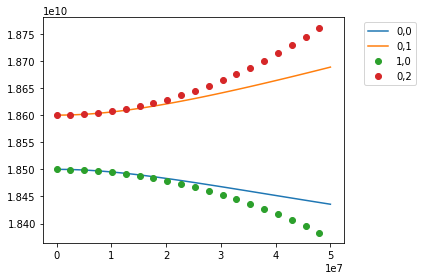

In [157]:
# Energy level diagram
plt.figure()
y = allEnergies[[11, 12]].T
plt.plot(couplings, y)
for i in [10, 13]:
    plt.plot(couplings[::5], analyticalEnergies[i][::5], 'o')
#plt.plot(couplings, analyticalEnergies[0], '--')
plt.legend(sortedLabels, ncol=1, bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.tight_layout()
#plt.savefig('energies-couplings.svg')
plt.show()

15 (1, 2) 0,1 - 1,0 499999999.9999981
42 (3, 4) 0,2 - 1,1 700000000.0
43 (3, 5) 0,2 - 2,0 899999999.9999943
54 (4, 5) 1,1 - 2,0 199999999.99999428
75 (6, 7) 0,3 - 1,2 900000000.0000286
84 (7, 8) 1,2 - 3,0 299999999.9999752
85 (7, 9) 1,2 - 2,1 399999999.9999981
92 (8, 9) 3,0 - 2,1 100000000.00002289
105 (10, 11) 1,3 - 2,2 599999999.9999657
106 (10, 12) 1,3 - 3,1 700000000.0000076
110 (11, 12) 2,2 - 3,1 100000000.00004196
117 (13, 14) 2,3 - 3,2 299999999.9999733


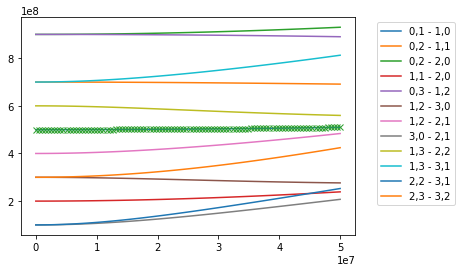

In [132]:
# Transition diagram
#selectedTransitions = [1, 26, 72, 133] #[1, 26, 49, 94, 112, 184] #[67, 101]#1, 17, 31, 58
selectedTransitions = list(range(len(transitionStateIndices)))
#selectedTransitions = [110]

plt.figure()
for t in selectedTransitions:
    index = transitionStateIndices[t]
    data1 = allEnergies[index[0]]
    data2 = allEnergies[index[1]]
    diff = data2 - data1
    if diff[0] < 1e9:
        print(t, index, transitionLabels[t], diff[0])
        plt.plot(couplings, diff, label=transitionLabels[t])
plt.plot(couplings, analyticalEnergies[4] - analyticalEnergies[1], 'x')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc="upper left")
plt.show()